# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


## Creating the forward model

In [4]:
ndim = 2
batch_size = 20000
means = np.array([2., 4.]).astype('float32')
stddevs = np.array([5., 7.]).astype('float32')
seed(12345)
npA = randn(2,16)
npB = randn(16,8)
npB2 = randn(8,32)
npC = randn(32,1)

tf.reset_default_graph()

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')

    # Defining the forward model
    # This is the linear operator
    A = tf.constant(npA, dtype=tf.float32) 
    xx = tf.matmul(x, A)
    xx = tf.nn.tanh(xx)

    A = tf.constant(npB, dtype=tf.float32) 
    xx = tf.matmul(xx, A)
    
    A = tf.constant(npB2, dtype=tf.float32) 
    xx = tf.matmul(xx, A)
    xx = tf.nn.tanh(xx)
    
    A = tf.constant(npC, dtype=tf.float32) 
    xx = tf.matmul(xx, A)

    l = tf.reduce_sum(xx, axis=1)
    l = tf.nn.softplus(l)
    p = tfd.Poisson(rate=l)
    y = tf.reshape(p.sample(), (-1,))

    hub.add_signature(inputs={'input':x}, 
                          outputs={'sample':y, 'lograte':l, 'transform':A})

    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module1 = hub.Module(spec, trainable=True)

# Defining probabilistic forward model
prior = tfd.Normal(loc=means, scale=stddevs)
x = prior.sample(batch_size)
l = module1({'input':x}, as_dict=True)['lograte']
y = module1({'input':x}, as_dict=True)['sample']
A = module1({'input':x}, as_dict=True)['transform']


sess = tf.Session()
sess.run(tf.global_variables_initializer())
sx, sy, sl, AA = sess.run([x, y, l, A])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
%%bash
ls modules/
rm -r modules/fwdmodel/


densemodule
fwdmodel


In [6]:
module1.export('./modules/fwdmodel', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/fwdmodel


/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


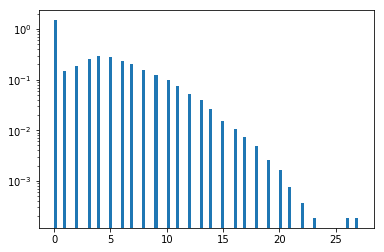

In [7]:
plt.hist(sy, bins=100, normed=True, log=True)
plt.show()

In [8]:
sl.max(), sy.max()

(11.969531, 27.0)

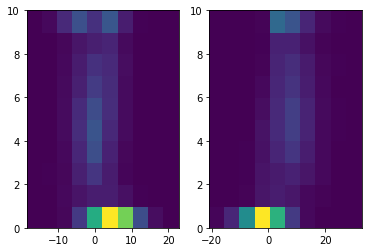

In [9]:
subplot(121)
# hist2d(sx[:,0], sy);
hist2d(sx[:,0], clip(sy.flatten(),0,10));
subplot(122)
# hist2d(sx[:,1], sy);
hist2d(sx[:,1], clip(sy.flatten(),0,10));

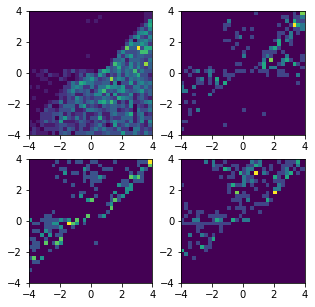

In [10]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
rrange =[[-4,4],[-4,4]]
for i in range(4):
    subplot(2,2,i+1)
    m = (sy == i)
    hist2d(sx[:,0][m], sx[:,1][m],32,range=rrange,normed=True);gca().set_aspect('equal');

In [11]:
# Now, let's try to train a neural network to model the likelihood function

# Module

Train a neural network in a module 

In [18]:

bs = 256

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')

    #reg = tf.contrib.layers.l2_regularizer(0.01)
    net = tf.layers.dense(x,512, activation=tf.nn.leaky_relu)#, kernel_regularizer=reg)
    net = tf.layers.dense(net,512, activation=tf.nn.leaky_relu) #, kernel_regularizer=reg)
    net = tf.layers.dense(net,512, activation=tf.nn.leaky_relu) #, kernel_regularizer=reg)
    net = tf.layers.dense(net,1)
#     net = tf.nn.softplus(net, name='lograte')
    out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


prior = tfd.Normal(loc=means, scale=stddevs)
xx = prior.sample(bs)
sy1 = module1({'input':xx}, as_dict=True)['sample']
lograte = module({'features':xx, 'labels':sy1}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':sy1}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':sy1}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]


for i in range(10000):
    l,_= sess.run([loss, train_op])
    losses.append(l)
    

# module.export('./densemodule', sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [24]:
pred = sess.run(module({'features':sx, 'labels':sy}, as_dict=True)['sample'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [25]:
pred.shape

(20000, 1)

In [26]:
sy

array([ 1.,  0.,  5., ...,  7.,  4., 10.], dtype=float32)

In [27]:
from matplotlib.colors import LogNorm

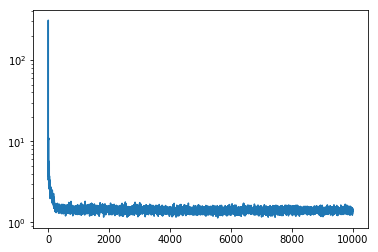

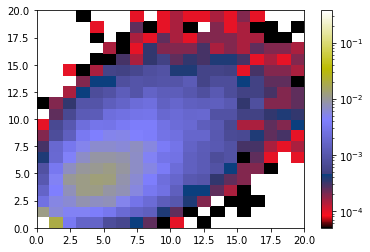

In [28]:

plot(losses)
plt.yscale('log')
plt.show()
plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern', normed=True, norm=LogNorm());
# plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.colorbar()
plt.show()

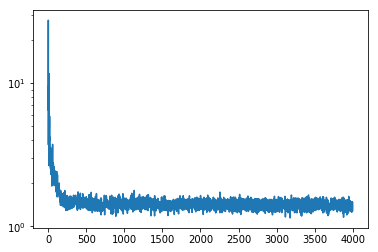

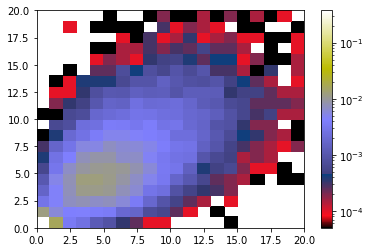

In [17]:

plot(losses)
plt.yscale('log')
plt.show()
plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern', normed=True, norm=LogNorm());
# plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.colorbar()
plt.show()

In [29]:
%%bash
ls modules/
rm -r ./modules/densemodule


densemodule
fwdmodel


In [30]:
module.export('./modules/densemodule', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemodule


Ok, fair enough

In [31]:
# Now, let's see what happens if we try to maximize p(y | x) with respect to x 


Ok, so there is a little bit of code restructuring to do, but the idea here is to see if when we do gradient descent over x, we end up far away from a credible input x value, by that I mean, is $\hat{x}$ within the posterior on x for y=4

# Reconstruct here

In [32]:

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    loglik = -module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
#     prior = tf.square(tf.add(xrecon, -means))
    prior = tf.square(xrecon)
    prior = tf.multiply(prior, stddevs**-2)
    prior = tf.reduce_sum(prior, axis=-1, keepdims=True)
    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

In [41]:
tf.reset_default_graph()
modname = './modules/densemodule/'
xfins = []
losses = []
priors = []
xinit = []

for i in range(6):
    ii = 2*i
    yy = ii* ones((512)).astype('float32')
    xi = 5*randn(512,2)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=5000, lr=0.01)
    xfin = np.squeeze(recons[0])
    xfins.append(xfin)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


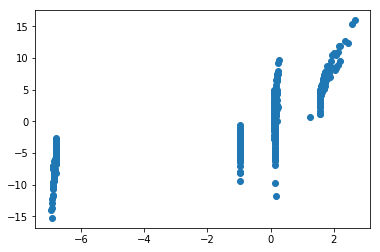

In [42]:
scatter(xfins[1][:,1], xinit[1][:,1])

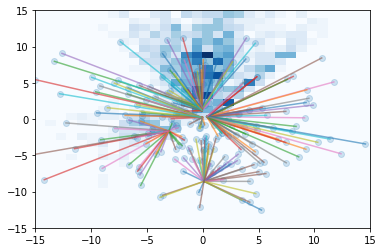

In [51]:
# With prior
i=2
ii = 2*i
m = (sy == ii)
hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-15,15],[-15,15]],normed=True, cmap='Blues') ;
plot([xinit[i][:200,0],xfins[i][:200,0]], [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);
scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2);

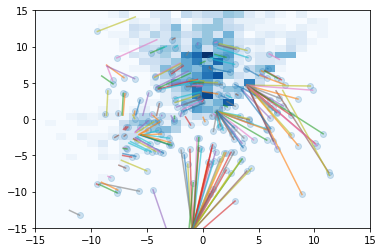

In [40]:
# Without prior
i=2
ii = 2*i
m = (sy == ii)
hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-15,15],[-15,15]],normed=True, cmap='Blues') ;
plot([xinit[i][:200,0],xfins[i][:200,0]], [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);
scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2);

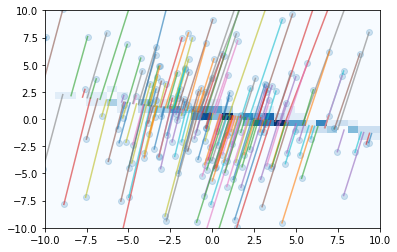

In [30]:
# Without prior on a very simple model
i=1
ii = 2*i
m = (sy == ii)
hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-10,10],[-10,10]],normed=True, cmap='Blues') ;
plot([xinit[i][:200,0],xfins[i][:200,0]], [xinit[i][:200,1],xfins[i][:200,1]],alpha=0.6);
scatter(xinit[i][:200,0], xinit[i][:200,1],alpha=0.2);

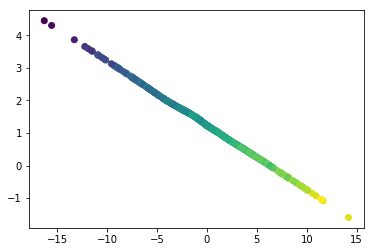

In [36]:
scatter(xfins[3][:,0], xfins[3][:,1], c=xinit[3][:,0])

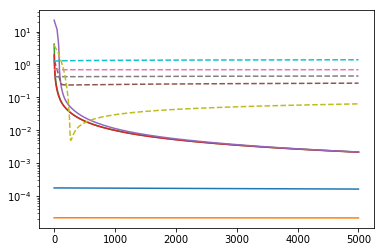

In [23]:
i = 0
for ii in np.random.randint(0, 512, 5):
    plt.plot(np.squeeze(np.array(losses[i])[:, ii]))
plt.yscale('log')
# plt.show()
for ii in np.random.randint(0, 512, 5):
    plt.plot(np.squeeze(np.array(priors[i])[:, ii]), '--')
plt.yscale('log')
plt.show()


0 8070
2 1013
4 1585
6 1251


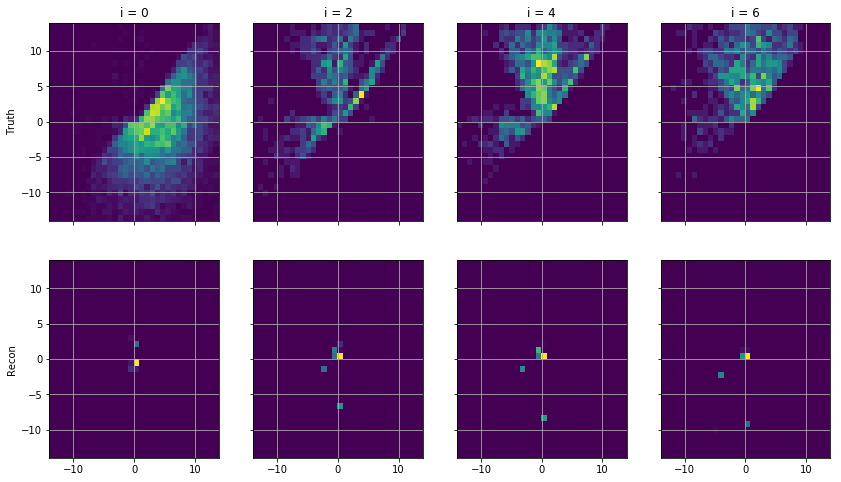

In [53]:
fig, ax = plt.subplots(2,4, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
                    32,range=[[-14,14],[-14,14]],normed=True)
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),
                    32, range=[[-14,14],[-14,14]],normed=True)
    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


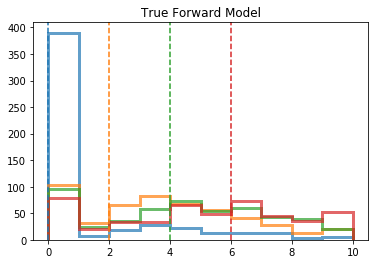

In [54]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        plt.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, histtype='step', lw=3)
        plt.axvline(2*i, color='C%d'%i, ls="--")
    plt.title('True Forward Model')

In [22]:
# for i in range(3):
#     rates = np.array([np.matmul(i, AA) for i in xfins[i]]).sum(axis=1)
#     plt.hist(np.random.poisson(np.exp(rates)), alpha=0.7, range=(0, 10), bins=10, color='C%d'%i)
#     plt.axvline(2*i, color='C%d'%i)
#     plt.title('True Forward Model')

# Custom dense layer

In [59]:
import sys
sys.path.append('./utils/')
import tfops, layers
from layers import SpecDenseLayer

In [ ]:
tf.reset_default_graph()

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')
    
    net = tf.concat([x, ]*(512//ndim), axis=1)
    net = net + SpecDenseLayer(512, activation=tf.nn.leaky_relu)(net)
    net = net + SpecDenseLayer(512, activation=tf.nn.leaky_relu)(net)
    net = net + SpecDenseLayer(512, activation=tf.nn.leaky_relu)(net)
    net = tf.layers.dense(net, 1, activation=tf.nn.softplus)
#     net = tf.nn.softplus(net, name='lograte')
    out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
lograte = module({'features':xx, 'labels':sy}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':sy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':sy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

lrate0 = sess.run(lograte, feed_dict={xx:sx[:10]})
for i in range(4000):
    l,_= sess.run([loss, train_op], feed_dict={xx:sx, lr:0.01})
    losses.append(l)
# for i in range(2000):
#     l,_= sess.run([loss, train_op], feed_dict={xx:sx, lr:0.0001})
#     losses.append(l)
lrate1 = sess.run(lograte, feed_dict={xx:sx[:10]})
pred = sess.run(sample, feed_dict={xx:sx})




./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
pred = sess.run(sample, feed_dict={xx:sx})

In [ ]:
# plot(losses)
# plt.yscale('log')
# plt.show()
hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
# plt.hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern', norm=LogNorm());
plt.colorbar()
plt.show()

In [60]:
%%bash
ls modules/
rm -r ./modules/specdensemodule


densemodule
fwdmodel
specdensemodule


In [61]:
module.export('./modules/specdensemodule', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/specdensemodule


In [62]:
tf.reset_default_graph()
modname = './modules/densemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    kern = sess.run(tf.get_collection('variables')[2])

tf.reset_default_graph()
modname = './modules/specdensemodule/'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[3]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/spec_dense_layer_1//kernelspecnorm/kernel:0' shape=(1000, 500) dtype=float32>


In [66]:
tf.get_collection('variables');


In [64]:
kernspec.shape

(1000, 500)

In [65]:
def poweriter(mat):
    u = np.random.normal(size=mat.shape[-1])
    for i in range(100):
        v = np.matmul(u, mat.T)
        v = v/np.linalg.norm(v)
        u = np.matmul(v, mat)
        u = u/np.linalg.norm(u)

    return np.matmul(np.matmul(v, mat), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(4.926815653286382, 42.50931982540253)

## recon again 

In [79]:
tf.reset_default_graph()
modname = './modules/specdensemodule/'
xfinsspec = []
losses = []
for i in range(4):
    ii = 2*i
    yy = ii* ones((512)).astype('float32')
    recons = dorecon(yy, modname, useprior=True, niter=4000, lr=0.01)
    xfin = np.squeeze(recons[0])
    losses.append(np.squeeze(recons[1]))
    xfinsspec.append(xfin)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


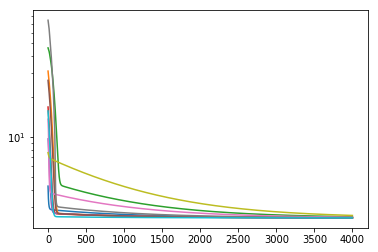

In [86]:
i = 3
for ii in np.random.randint(0, 512, 10):
    plt.plot(np.squeeze(np.array(losses[i])[:, ii]))
plt.yscale('log')
plt.show()


0 14803
2 125
4 116
6 111


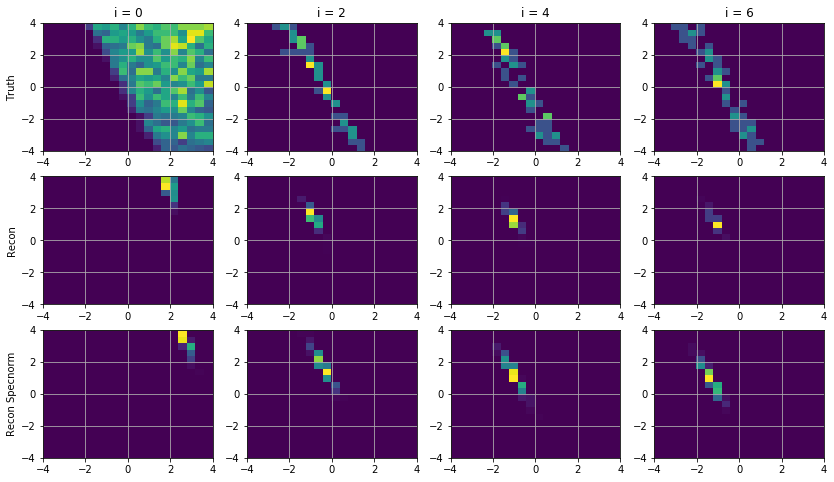

In [84]:
nbins = 20
fig, ax = plt.subplots(3,4, figsize=(14, 8), sharex=False, sharey=False)
for i in range(4):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
                    nbins,range=[[-4,4],[-4,4]],normed=True)
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),
                    nbins, range=[[-4,4],[-4,4]],normed=True)
    ax[2, i].hist2d(xfinsspec[i].T[0].flatten(), xfinsspec[i].T[1].flatten(),
                    nbins, range=[[-4,4],[-4,4]],normed=True)
#     ax[2, i].hist2d(xfinsspec[i].T[0].flatten(), xfinsspec[i].T[1].flatten(),
#                     nbins, normed=True)

    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    ax[2, 0].set_ylabel('Recon Specnorm')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


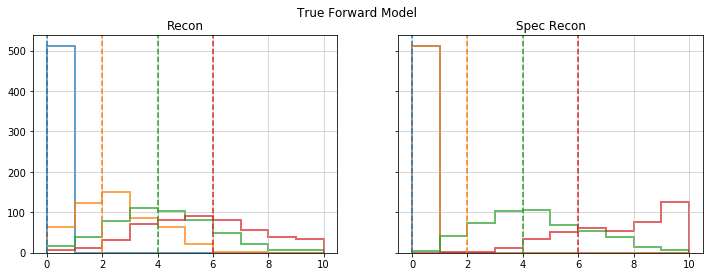

In [85]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

fig, axar = plt.subplots(1, 2, figsize = (12, 4), sharey=True)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[0]
        ax.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, 
                 histtype='step', lw=2)
        ax.axvline(2*i, color='C%d'%i, ls="--")
        ax.set_title('Recon')
        
        samples = fwmodule({'input':xfinsspec[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[1]
        ax.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, 
                 histtype='step', lw=2, ls="-")
        ax.set_title('Spec Recon')
        
        ax.axvline(2*i, color='C%d'%i, ls="--")
plt.suptitle('True Forward Model')
for axis in axar: axis.grid(lw=0.5)